# NLP with PyTorch

Network Theory:
- **Recurrent Neural Network (RNN)**: Neural network designed to ***process sequential data***, where the order of information matters, like **text** or **time series data**.

RNNs feed information back into the network at each step.

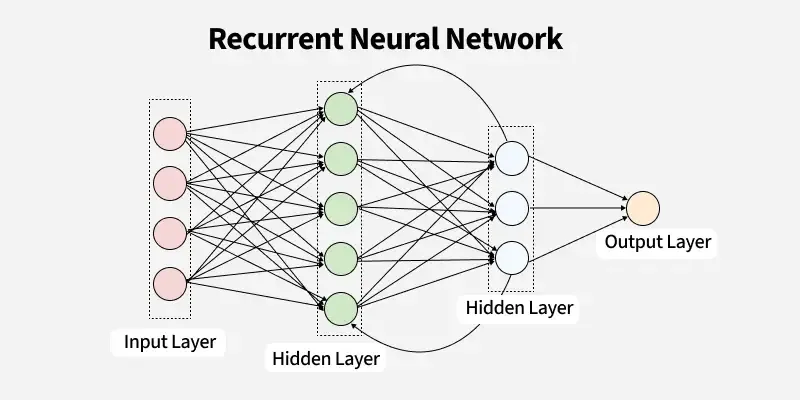

"Imagine reading a sentence and you try to predict the next word, you don’t rely only on the current word but also remember the words that came before."

## Key Components of RNNs:

1. **Recurrent Neurons**  

   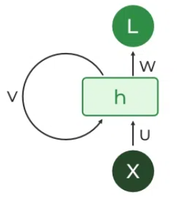  
   
   *Fundamental processing unit that holds a hidden state and maintains information about previous inputs in a sequence. Recurrent units can "remember" information from prior steps by feeding back their hidden state, allowing them to capture dependencies across time.*

2. **RNN Unfolding**  

   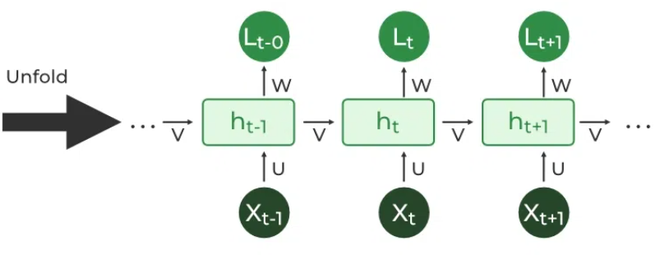
   
   *RNN unfolding or unrolling is the process of expanding the recurrent structure over time steps. During unfolding each step of the sequence is represented as a separate layer in a series illustrating how information flows across each time step.*


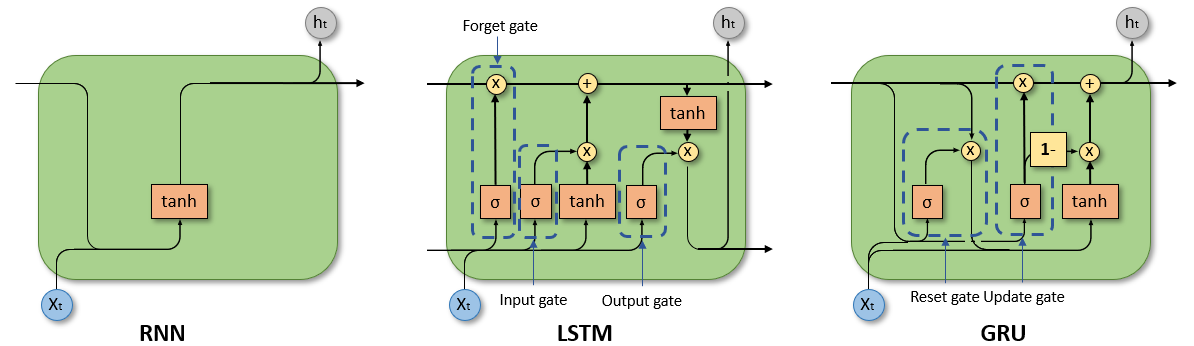

**RNN (Recurrent Neural Network)**

*Note: In RNN weights and bias for all the nodes in the layer are the same*

***Architecture***:
- Xt: Current input at time step "t"
- $h_{t-1}$: Hidden state from the previous time step (the "memory")
- Through activation function (tanh)

***Process***:
1. RNN combines the current input $x_{t}$ and previous hidden state $h_{t-1}$
2. Combine input goes through a *non-linear activation function* ($tanh$ or $ReLU$) 
3. Output is $h_{t}$: new hidden state (passsed to the next time step)


***Problem***:
- Vanishing gradient: When RNN doing the backpropagation through time, the update is gradually become smaller and smaller, and it makes the network does not learn the effect of earlier inputs and not affect the weight updation. -> Short-Term memory problem

$$ 
h_{t} = tanh(W_{hh} . h_{t-1} + W_{xh}.x_{t}) 
$$

Where:
- $W_{xh}$: Weight matrix that connect input $x_{t}$ to the hidden layer
- $W_{hh}$: Weight matrix that connects previous hidden state $h_{t-1}$ to current

In [3]:
# PyTorch Core
import torch                          # Core PyTorch Library
import torch.nn as nn                 # Neural Network

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size

        # Define the weight matrices and bias terms
        # Weight matrix: input (xₜ) to hidden state (hₜ)
        self.Wxh = nn.Parameter(torch.randn(hidden_size, input_size))
        # Weight matrix: previous hidden state (hₜ₋₁) to current hidden state (hₜ)
        self.Whh = nn.Parameter(torch.randn(hidden_size, hidden_size))
        # Weight matrix: hidden state (hₜ) to output (yₜ)
        self.Why = nn.Parameter(torch.randn(output_size, hidden_size))
        # Bias for hidden state computation
        self.bh = nn.Parameter(torch.zeros(hidden_size))
        # Bias for output computation
        self.by = nn.Parameter(torch.zeros(output_size))

    def forward(self, input_seq, h_0):
        """
        Forward pass for the Simple RNN.

        Parameters:
        - input_seq: Tensor of shape (seq_length, input_size)
        - h_0: Initial hidden state of shape (hidden_size,)

        Returns:
        - output_seq: Tensor of shape (seq_length, output_size)
        - h_n: Final hidden state of shape (hidden_size,)
        """

        seq_length = input_seq.shape[0]
        output_seq = torch.zeros(seq_length, self.by.shape[0])

        # Intialize hidden state
        h_t = h_0

        for t in range(seq_length):
            # Input at time step t
            x_t = input_seq[t]   

            # Update hidden step at time step t
            # Similar with torch.nn.Linear()
            h_t = torch.tanh(torch.matmul(self.Wxh, x_t) + torch.matmul(self.Whh, h_t) + self.bh)

            # Compute the output at time step t
            y_t = torch.matmul(self.Why, h_t) + self.by

            # Store the output for time step t in the output sequence
            output_seq[t] = y_t

        return output_seq, h_t



**Gated Recurrent Units**

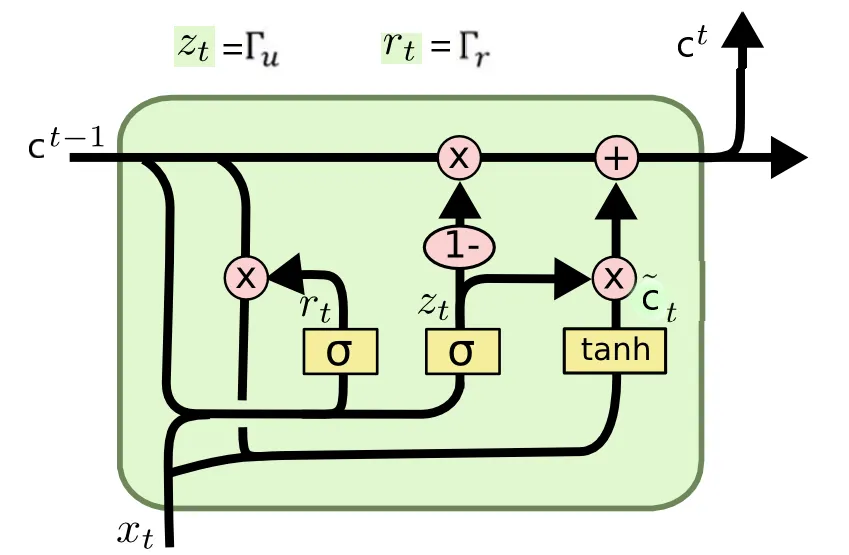

*Note: ***Gates*** are capable of learning which inputs in the sequence are important and store their information in the memory unit. They can pass the information in long sequences and use them to make predictions.*

Inside GRU it has two gates:
1. Reset Gate ($R_{r}$)
    
    Used to decide whether the previous cell state is important or not. Sometimes the reset gate is not used in simple GRU.
    
2. Update Gate ($R_{u}$)
   
   Decides if the cell state should be updated with the candidate state(current activation value)or not.


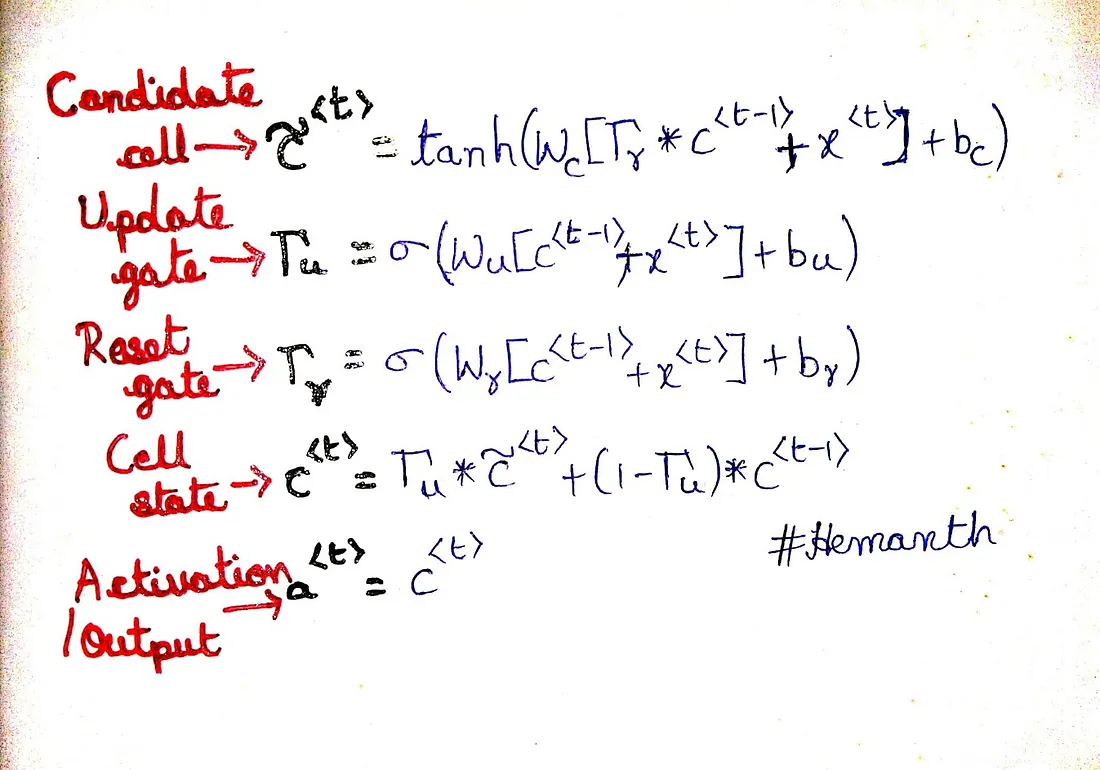

- Candidate Cell ($C^{t-1}$)

   Simply the same as the hidden state(activation) of RNN.

- Final Cell State ($C^{t}$)

   The final cell state is dependent on the update gate. It may or may not be updated with candidate state. Remove some content from last cell state, and write some new cell content.

***In GRU the final cell state is directly passing as the activation to the next cell.***

In GRU:
- If reset close to 0, ignore previous hidden state (allows the model to drop information that is irrelevant in the future).
- If gamma(update gate) close to 1, then we can copy information in that unit through many steps!
- Gamma Controls how much of past state should matter now.

### GRU Process:
1. Input $x_{t}$ and previous hidden state $c^{t-1}$ are both used to compute:
   - Reset gate $r_{t}$: $\sigma(W_{r}.[x_{t},c^{t-1}])$
   - Update gate $z_{t}$: $\sigma(W_{z}.[x_{t},c^{t-1}])$
2. ***Reset gate*** $r_{t}$ controls how much of the past ($c^{t-1}$) to ***forget***:
   - If $r_{t}$ close to 0 -> ignore most of the past.
   - Element-wise multiplied with $c^{t-1}$, controlling memory flow.
3. ***Candidate state*** $c^{`t}$ is the calculated using:
   - $\tilde{c^{t}} = tanh(W.[x_{t}, r_{t}.c^{t-1}])$
   - It's the "new" possible hidden state if we were to fully replace the old one.
4. Finally, we comput the final hidden state $c^{t}$:
$$c^{t} = (1 - z_{t}) . c^{t-1} + z_{t}.\tilde{c^{t}}$$
   - If $z_{t}$ equal to 1: we favor the new candidate $c^{t}$
   - If $z_{t}$ equal to 0: we mostly keep the previous state $c^{t}$

In [11]:
class CustomGRUCell(nn.Module):
    def __init_(self, input_size, hidden_size):
        super(CustomGRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Weights and biases fro the reset and update gates
        self.Wr = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.br = nn.Parameter(torch.zeros(hidden_size))

        self.Wz = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.bz = nn.Parameter(torch.zeros(hidden_size))

        # Weights and biases for the candidate hidden state
        self.Wh = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.bh = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_t):
        """
        Forward Pass for the GRU cell.

        Parameters:
        - x: Input at current time step of shape (batch_size, input_size)
        - h_t: Hidden state at previous time step of shape (batch_size, hidden_size)

        Returns:
        - h_t_next: Hidden state at current time step of shape (batch_size, hidden_size)
        """
        # Combine input and previous hidden state
        combined = torch.cat((x, h_t), dim = 1)

        # Reset gate
        r_t = torch.sigmoid(torch.matmul(self.Wr, combined.t()) + self.br.unsqueeze(1))
        # Update gate
        z_t = torch.sigmoid(torch.matmul(self.Wz, combined.t()) + self.br.unsqueeze(1))

        # Concetenate the reset gate with the input for the hidden state
        reset_x = r_t * h_t
        combined_reset = torch.cat((reset_x, x), dim = 1)

        # Candidate hidden state
        h_tilde_t = torch.tanh(torch.matmul(self.Wh, combined_reset.t()) + self.br.unsqueeze(1))

        # Update the hidden state using the update gate
        h_t_next = (1 - z_t) * h_t + z_t * h_tilde_t

        return h_t_next
    
class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(CustomGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Initialize GRU cells for each layer
        self.cells = nn.ModuleList((CustomGRUCell(input_size) 
                                    if layer == 0 else hidden_size, hidden_size) 
                                    for layer in range(num_layers)
                                  )
        
    def forward(self, x, h_0=None):
        """
        Forward Pass for the GRU Layer.

        Parameters:
        - x: Input sequence of shape (seq_length, batch_size, input_size)
        - h_0: Initial hidden state of shape (num_layers, batch_size, hidden_size)

        Returns:
        - output_seq: Output sequence of shape (seq_length, batch_size, hidden_size)
        - h_n: Final hiddens tate of shape (num_layers, batch_size, hidden_size)
        """

        seq_length, batch_size, _ = x.shape
        h_t = torch.zeros(self.num_layers, batch_size, self.hidden_size) if h_0 is None else h_0

        output_seq = torch.zeros(seq_length, batch_size, self.hidden_size)

        for t in range(seq_length):
            input_t = x[t]

            for layer in range(self.num_layers):
                h_t[layer] = self.cells[layer](input_t, h_t[layer])
                input_t = h_t[layer]

            output_seq[t] = h_t[-1]

        return output_seq, h_t

**LSTM (Long Short Term Memory)**

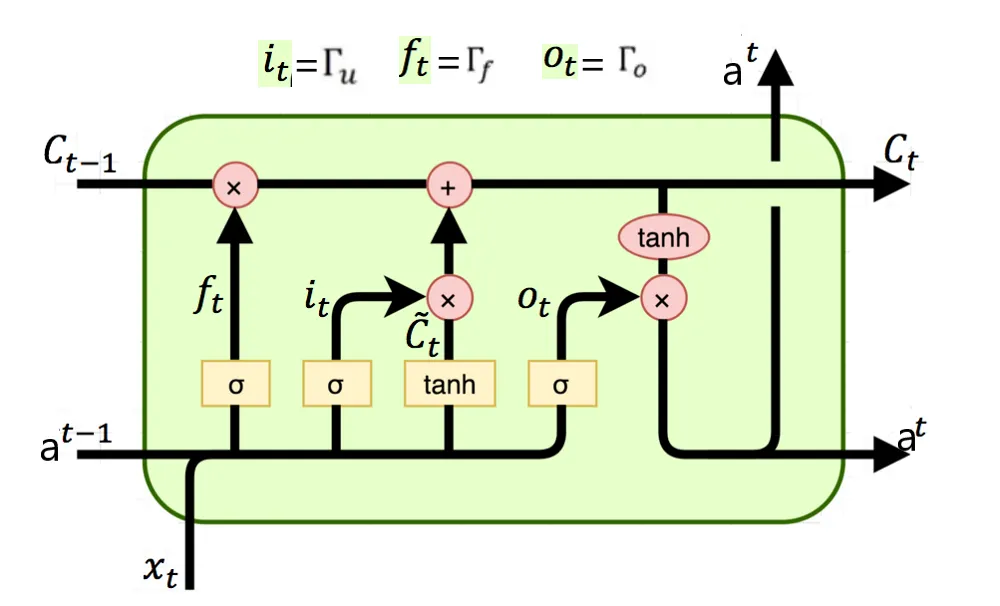

The Operation inside it:

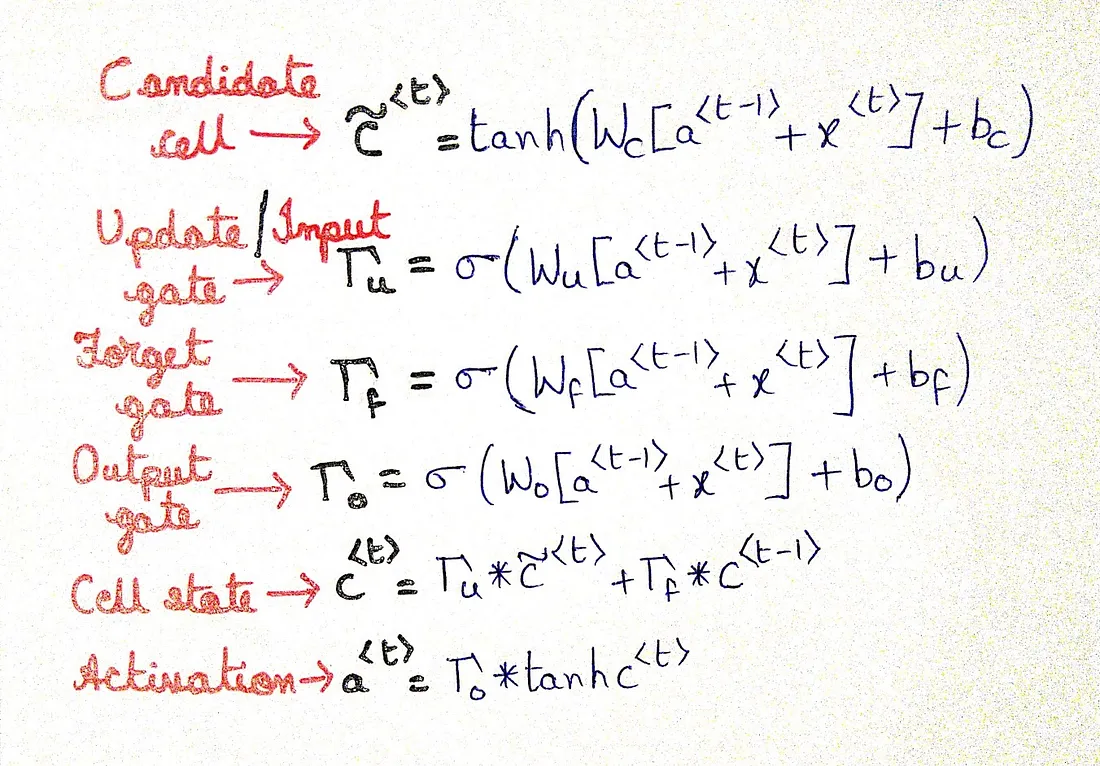


*All 3 gates(input gate, output gate, forget gate) use sigmoid as activation function so all gate values are between 0 and 1.*


- Forget Gate ($R_{f}$ or $f_{t}$)
  
  It controls what is kept vs forgotten, from previous cell state. In laymen terms, it will decide **how much information from the previous state should be kept and forget remaining**.

- Output Gate ($R_{o}$ or $o_{t}$)

  It controls which parts of the cell are output to the hidden state. It will **determine what the next hidden state will be**.


### LSTM Process:

1. Combine input `x_t` and hidden state `a_{t-1}`
2. Pass through gates:
   - `f_t`: forget gate → decides what to discard from `C_{t-1}`
   - `i_t`: input gate → decides what new info to add
   - `~C_t`: candidate cell → new memory proposal (tanh)
3. Update memory:
   - `C_t = f_t * C_{t-1} + i_t * ~C_t`
4. Output hidden state:
   - `o_t`: output gate → regulates what to output
   - `a_t = o_t * tanh(C_t)`

Source: https://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573

In [9]:
class CustomLSTMCell(nn.Module):
    def __init__(sefl, input_size, hidden_size):
        super(CustomLSTMCell, sefl).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Weights and biases for the forget, input, ouput, and cell state gate
        self.Wf = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.bf = nn.Parameter(torch.zeros(hidden_size))

        self.Wi = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.bi = nn.Parameter(torch.zeros(hidden_size))

        self.Wo = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.bo = nn.Parameter(torch.zeros(hidden_size))

        self.Wc = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.bc = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_t, c_t):
        """
        Forward pass for the LSTM cell.

        Parameters:
        - x: Input at current time step of shape (batch_size, input_size)
        - h_t: Previous hidden state (batch_size, hidden_size)
        - c_t: Previous Cell State (batch_size, hidden_size)

        Returns:
        - h_t_next: Current Hidden State
        - c_t_next: Current Cell State
        """

        combined = torch.cat((x, h_t), dim=1)

        # Forget gate
        f_t = torch.sigmoid(torch.matmul(self.Wf, combined.t()) + self.bf.unsqueeze(1))
        # Input Gate
        i_t = torch.sigmoid(torch.matmul(self.Wi, combined.t()) + self.bf.unsqueeze(1))
        # Output Gate
        o_t = torch.sigmoid(torch.matmul(self.Wo, combined.t()) + self.bf.unsqueeze(1))
        # Candidate Cell State
        c_tilde_t = torch.sigmoid(torch.matmul(self.Wc, combined.t()) + self.bf.unsqueeze(1))

        c_t_next = f_t * c_t + i_t * c_tilde_t
        h_t_next = o_t * torch.tanh(c_t_next)

        return h_t_next, c_t_next
    
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(CustomLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self. num_layers = num_layers

        # Initalize LSTM cells for each layer
        self.cells = nn.ModuleList([CustomLSTMCell(input_size if layer == 0 else hidden_size, hidden_size) 
                                    for layer in range(num_layers)
        ])

    def forward(self, x, h_0=None, c_0=None):
        """
        Forward Pass for the LSTM Layer

        Parameters:
        - x: Input sequence of shape (seq_length, batch_size, input_size)
        - h_0: Intial hidden state of shape (num_layers, batch_size, hidden_size)
        - c_0: Initial cell state of shape (num_layers, batch_size, hidden_size)

        Returns:
        - output_seq: Output sequence of shape (seq_length, batch_size, hidden_size)
        - h_n: Final hidden state of shape (num_layers, batch_size, hidden_size)
        - c_n: Final cell state of shape (num_layers, batch_size, hidden_size) 
        """

        seq_length, batch_size, _ = x.shape
        
        # Intialize hidden and cell states
        h_t = torch.zeros(self.num_layers, batch_size, self.hidden_size) if h_0 is None else h_0
        c_t = torch.zeros(self.num_layers, batch_size, self.hidden_size) if c_0 is None else c_0
        
        output_seq = torch.zero(seq_length, batch_size, self.hidden_size)

        for t in range(seq_length):
            input_t = x[t]

            for layer in range(self.num_layers):
                h_t[layer], c_t[layer] = self.cells[layer](input_t, h_t[layer], c_t[layer])
                # Feed Output of Current Layer to Next
                input_t = h_t[layer]

            output_seq[t] = h_t[-1]

        return output_seq, h_t, c_t